# Whatprot datasets

In this notebook we will test results from datasets created with whatprot and then exported to GPU format. This decision of changing the generation was because the simulation through erisyon was not working both for simulation and classifier generation, and we did not have control of the steps. With whatprot we can generate with our own computer the simulations, at least for the oracle.

In [25]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
import re

results_path="/home/jkipen/ProtInfGPU/results/"
opt_prot_inf="./../code/cuda/opt.out" 

In [149]:
##Common functions
def ret_config(config_path, key):
    with open(config_path, "r") as file:
        for line in file:
            if line.startswith(key + ":"):
                return line.split(":")[1].strip()  # Get the value after ':' and remove spaces
    return None  # Return None if the key is not found
def get_data_from_experiment_oracle_perr(exp_path): #Gets the data to compare oracle p_errs!
    df=pd.read_csv(exp_path+'/ErrVsEpochs.csv')
    df_numpy=df.to_numpy()
    x=df_numpy[:,0]; y=df_numpy[:,1];  y_err=df_numpy[:,2]/2
    p_err=ret_config(exp_path+"/RunConfig.txt","Oracle Perr")
    return x,y,y_err,p_err

def get_data_from_experiment_oracle_perr(exp_path): #Gets the data to compare oracle p_errs!
    df=pd.read_csv(exp_path+'/ErrVsEpochs.csv')
    df_numpy=df.to_numpy()
    x=df_numpy[:,0]; y=df_numpy[:,1];  y_err=df_numpy[:,2]/2
    p_err=ret_config(exp_path+"/RunConfig.txt","Oracle Perr")
    return x,y,y_err,p_err

def get_data_from_experiment_oracle_subset(exp_path):
    df=pd.read_csv(exp_path+'/ErrVsEpochs.csv')
    df_numpy=df.to_numpy()
    x=df_numpy[:,0]; y=df_numpy[:,1];  y_err=df_numpy[:,2]/2
    n_subset=ret_config(exp_path+"/RunConfig.txt","NsubsetCV")
    return x,y,y_err,n_subset

def get_eq_guess(n_prot,n_dists_est=1000):
    exponential_vars = np.random.exponential(size=(n_dists_est, n_prot))
    random_dists = exponential_vars / exponential_vars.sum(axis=1, keepdims=True)
    equidis_err = np.mean(np.mean(np.abs(random_dists-np.ones(shape=(n_dists_est,n_prot))/n_prot),axis=1))
    return equidis_err

def compare_oracle_dif_errs(n_prot,log=True):
    out_path=results_path+"/"+str(n_prot)+"_Prot/Oracle_dif_errs/";
    plt.figure()
    plt.ylabel("MAE")
    plt.xlabel("N Epochs")
    xs=[];ys=[];y_errs=[];p_errs=[];
    with os.scandir(out_path) as entries:
        for entry in entries:
            if entry.is_dir() and re.match(r"^\d", entry.name):  # Only consider directories that starts with numbers
                x,y,y_err,p_err=get_data_from_experiment_oracle_perr(os.path.join(out_path, entry.name))
                xs.append(x);ys.append(y);y_errs.append(y_err);p_errs.append(float(p_err));
                #plt.errorbar(x, y,  yerr=y_err, label= "Oracle p=" + p_err)

    sorted_data = sorted(zip(p_errs, xs, ys, y_errs), key=lambda t: t[0])  
    p_errs, xs, ys, y_errs = zip(*sorted_data)  # Unpack sorted data

    for x, y, y_err, p_err in zip(xs, ys, y_errs, p_errs):
        plt.errorbar(x, y, yerr=y_err, label=f"Oracle p={p_err}")
    equidis_err=get_eq_guess(n_prot)
    plt.axhline(y=equidis_err, color='red', linestyle='dotted', label=f'Equidistributed Error = {equidis_err:.5f}')

    plt.legend()
    plt.title("Oracle perr comp")
    if log:
        plt.yscale('log')
    plt.grid()
    #plt.ylim([0, 0.005])
    plt.show()
    
def compare_oracle_subsets(n_prot,log=True,subfolder="Oracle_subsets/"):
    out_path=results_path+"/"+str(n_prot)+"_Prot/"+subfolder;
    plt.figure()
    plt.ylabel("MAE")
    plt.xlabel("N Epochs")
    xs=[];ys=[];y_errs=[];n_subsets=[];
    with os.scandir(out_path) as entries:
        for entry in entries:
            if entry.is_dir() and re.match(r"^\d", entry.name):  # Only consider directories that starts with numbers
                x,y,y_err,n_subset=get_data_from_experiment_oracle_subset(os.path.join(out_path, entry.name))
                xs.append(x);ys.append(y);y_errs.append(y_err);n_subsets.append(float(n_subset));
                #plt.errorbar(x, y,  yerr=y_err, label= "Oracle p=" + p_err)

    sorted_data = sorted(zip(n_subsets, xs, ys, y_errs), key=lambda t: t[0])  
    n_subsets, xs, ys, y_errs = zip(*sorted_data)  # Unpack sorted data

    for x, y, y_err, n_subset in zip(xs, ys, y_errs, n_subsets):
        plt.errorbar(x, y, yerr=y_err, label="Oracle "+ "{:.2E}".format(n_subset) +"samples")
    equidis_err=get_eq_guess(n_prot)
    plt.axhline(y=equidis_err, color='red', linestyle='dotted', label=f'Equidistributed Error = {equidis_err:.5f}')

    plt.legend()
    plt.title("Oracle perr comp")
    if log:
        plt.yscale('log')
    plt.grid()
    #plt.ylim([0, 0.005])
    plt.show()

# 50 Prot


In [26]:
#Parameters we will tune
n_epochs=60;
subset=500000;
oracle_err=0;
cv_runs=10;
in_path= "/home/jkipen/raid_storage/ProtInfGPU/data/50_Prot/binary/Oracle"
out_path= "/home/jkipen/ProtInfGPU/results/50_Prot/Oracle_dif_errs"

In [27]:
oracle_errs=[0,0.01, 0.05, 0.1, 0.2, 0.3 ,0.4, 0.5]
for oracle_err in oracle_errs:
    base_command= opt_prot_inf + " " + in_path + " " +out_path 
    command= base_command + " -d 3 -e "+str(n_epochs) +" -c "+str(cv_runs)+" -m 50 -M 30 -s "+str(subset)+" -t 128 -o "+str(oracle_err);
    print(command)
    os.system(command)

./../code/cuda/opt.out /home/jkipen/raid_storage/ProtInfGPU/data/50_Prot/binary/Oracle /home/jkipen/ProtInfGPU/results/50_Prot/Oracle_dif_errs -d 3 -e 60 -c 10 -m 50 -M 30 -s 500000 -t 128 -o 0
./../code/cuda/opt.out /home/jkipen/raid_storage/ProtInfGPU/data/50_Prot/binary/Oracle /home/jkipen/ProtInfGPU/results/50_Prot/Oracle_dif_errs -d 3 -e 60 -c 10 -m 50 -M 30 -s 500000 -t 128 -o 0.01
./../code/cuda/opt.out /home/jkipen/raid_storage/ProtInfGPU/data/50_Prot/binary/Oracle /home/jkipen/ProtInfGPU/results/50_Prot/Oracle_dif_errs -d 3 -e 60 -c 10 -m 50 -M 30 -s 500000 -t 128 -o 0.05
./../code/cuda/opt.out /home/jkipen/raid_storage/ProtInfGPU/data/50_Prot/binary/Oracle /home/jkipen/ProtInfGPU/results/50_Prot/Oracle_dif_errs -d 3 -e 60 -c 10 -m 50 -M 30 -s 500000 -t 128 -o 0.1
./../code/cuda/opt.out /home/jkipen/raid_storage/ProtInfGPU/data/50_Prot/binary/Oracle /home/jkipen/ProtInfGPU/results/50_Prot/Oracle_dif_errs -d 3 -e 60 -c 10 -m 50 -M 30 -s 500000 -t 128 -o 0.2
./../code/cuda/opt.o

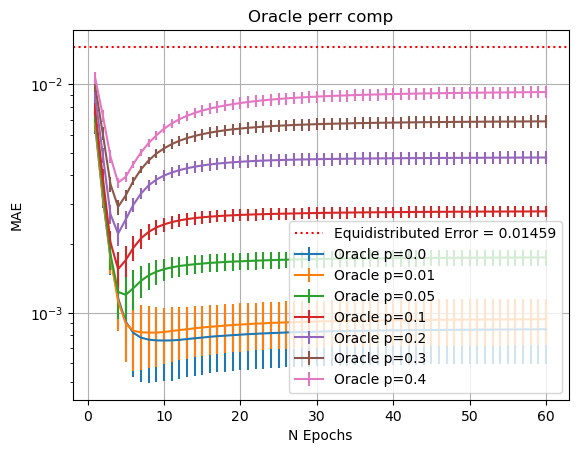

In [29]:
compare_oracle_dif_errs(50)

In [30]:
out_path= "/home/jkipen/ProtInfGPU/results/50_Prot/Oracle_subsets"
oracle_err=0;
subsets=[50000,100000,250000,500000,750000,1000000]
for subset in subsets:
    base_command= opt_prot_inf + " " + in_path + " " +out_path 

    command= base_command + " -d 3 -e "+str(n_epochs) +" -c "+str(cv_runs)+" -m 50 -M 30 -s "+str(subset)+" -t 128 -o "+str(oracle_err);
    print(command)
    os.system(command)

./../code/cuda/opt.out /home/jkipen/raid_storage/ProtInfGPU/data/50_Prot/binary/Oracle /home/jkipen/ProtInfGPU/results/50_Prot/Oracle_subsets -d 3 -e 60 -c 10 -m 50 -M 30 -s 50000 -t 128 -o 0
./../code/cuda/opt.out /home/jkipen/raid_storage/ProtInfGPU/data/50_Prot/binary/Oracle /home/jkipen/ProtInfGPU/results/50_Prot/Oracle_subsets -d 3 -e 60 -c 10 -m 50 -M 30 -s 100000 -t 128 -o 0
./../code/cuda/opt.out /home/jkipen/raid_storage/ProtInfGPU/data/50_Prot/binary/Oracle /home/jkipen/ProtInfGPU/results/50_Prot/Oracle_subsets -d 3 -e 60 -c 10 -m 50 -M 30 -s 250000 -t 128 -o 0
./../code/cuda/opt.out /home/jkipen/raid_storage/ProtInfGPU/data/50_Prot/binary/Oracle /home/jkipen/ProtInfGPU/results/50_Prot/Oracle_subsets -d 3 -e 60 -c 10 -m 50 -M 30 -s 500000 -t 128 -o 0
./../code/cuda/opt.out /home/jkipen/raid_storage/ProtInfGPU/data/50_Prot/binary/Oracle /home/jkipen/ProtInfGPU/results/50_Prot/Oracle_subsets -d 3 -e 60 -c 10 -m 50 -M 30 -s 750000 -t 128 -o 0
./../code/cuda/opt.out /home/jkipen/

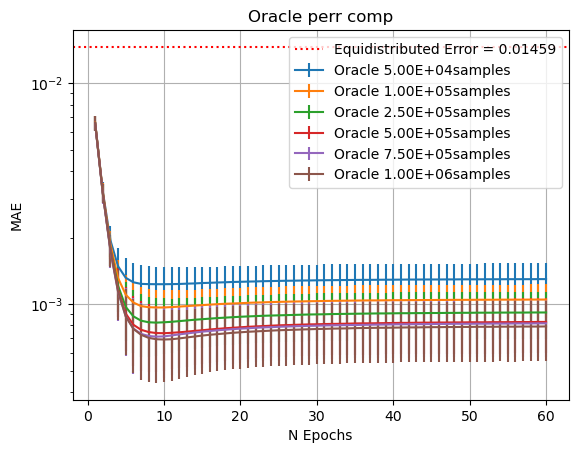

In [31]:
compare_oracle_subsets(50)

# 1000 Prot


In [32]:
#Parameters we will tune
n_epochs=60;
subset=500000;
oracle_err=0;
cv_runs=10;
in_path= "/home/jkipen/raid_storage/ProtInfGPU/data/1000_Prot/binary/Oracle"
out_path= "/home/jkipen/ProtInfGPU/results/1000_Prot/Oracle_dif_errs"

In [39]:
out_path= "/home/jkipen/ProtInfGPU/results/1000_Prot/Oracle_subsets"
oracle_err=0;
#subsets=[50000,100000,250000,500000,750000,1000000,2000000,5000000,10000000]
subsets=[10000000]
for subset in subsets:
    base_command= opt_prot_inf + " " + in_path + " " +out_path 

    command= base_command + " -d 3 -e "+str(n_epochs) +" -c "+str(cv_runs)+" -m 50 -M 30 -s "+str(subset)+" -t 128 -o "+str(oracle_err);
    print(command)
    os.system(command)

./../code/cuda/opt.out /home/jkipen/raid_storage/ProtInfGPU/data/1000_Prot/binary/Oracle /home/jkipen/ProtInfGPU/results/1000_Prot/Oracle_subsets -d 3 -e 60 -c 10 -m 50 -M 30 -s 10000000 -t 128 -o 0


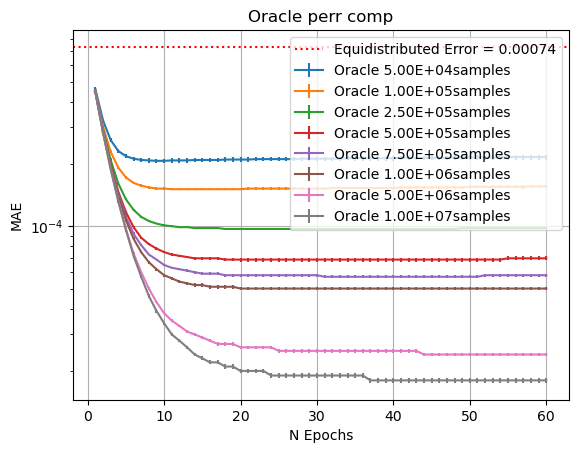

In [40]:
compare_oracle_subsets(1000)

In [ ]:
subset=1000000;
oracle_errs=[0,0.01, 0.05, 0.1, 0.2, 0.3 ,0.4, 0.5]
for oracle_err in oracle_errs:
    base_command= opt_prot_inf + " " + in_path + " " +out_path 
    command= base_command + " -d 3 -e "+str(n_epochs) +" -c "+str(cv_runs)+" -m 50 -M 30 -s "+str(subset)+" -t 128 -o "+str(oracle_err);
    print(command)
    os.system(command)

# Whole proteome

In [63]:
dir_exp_whole_prot="/home/jkipen/ProtInfGPU/results/20660_Prot/Oracle_dif_errs/"
x,y,y_err,n_subset=get_data_from_experiment_oracle_subset(dir_exp_whole_prot+"21-02-2025_12-54-35")
x2,y2,y_err2,n_subset2=get_data_from_experiment_oracle_subset(dir_exp_whole_prot+"21-02-2025_16-12-36")

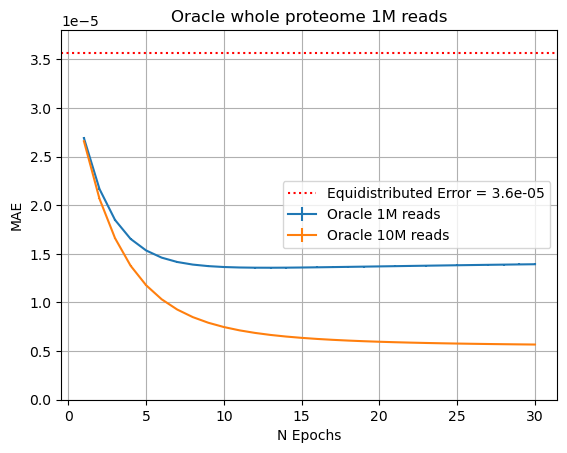

In [64]:
plt.figure()
plt.ylabel("MAE")
plt.xlabel("N Epochs")
n_prot=20660-18; #18 prots did not provide any flu exp.

plt.errorbar(x, y, yerr=y_err, label=f"Oracle 1M reads")
plt.errorbar(x2, y2, yerr=y_err2, label=f"Oracle 10M reads")
equidis_err=get_eq_guess(n_prot)
plt.axhline(y=equidis_err, color='red', linestyle='dotted', label=f'Equidistributed Error = {equidis_err:.2g}')

plt.legend()
plt.title("Oracle whole proteome 1M reads")
#if log:
#    plt.yscale('log')
plt.grid()
plt.ylim([0, 3.8e-5])
plt.show()

It took a long time, so we had to further optimize the code and now we can run:

In [ ]:
in_path= "/home/jkipen/raid_storage/ProtInfGPU/data/20660_Prot/binary/Oracle"
out_path= "/home/jkipen/ProtInfGPU/results/20660_Prot/Oracle_Plot_No_Err"
oracle_err=0;
n_epochs=30;
subset=500000;
oracle_err=0;
cv_runs=10;
n_threads=512;
#subsets=[50000,100000,250000,500000,750000,1000000,2000000,5000000,10000000]
subsets=[1000000,2000000,5000000]
for subset in subsets:
    base_command= opt_prot_inf + " " + in_path + " " +out_path 

    command= base_command + " -d 2 -e "+str(n_epochs) +" -c "+str(cv_runs)+" -m 50 -M 30 -s "+str(subset)+" -t " + str(n_threads)+" -o "+str(oracle_err);
    print(command)
    os.system(command)

./../code/cuda/opt.out /home/jkipen/raid_storage/ProtInfGPU/data/20660_Prot/binary/Oracle /home/jkipen/ProtInfGPU/results/20660_Prot/Oracle_Plot_No_Err -d 2 -e 30 -c 10 -m 50 -M 30 -s 1000000 -t 512 -o 0
./../code/cuda/opt.out /home/jkipen/raid_storage/ProtInfGPU/data/20660_Prot/binary/Oracle /home/jkipen/ProtInfGPU/results/20660_Prot/Oracle_Plot_No_Err -d 2 -e 30 -c 10 -m 50 -M 30 -s 2000000 -t 512 -o 0


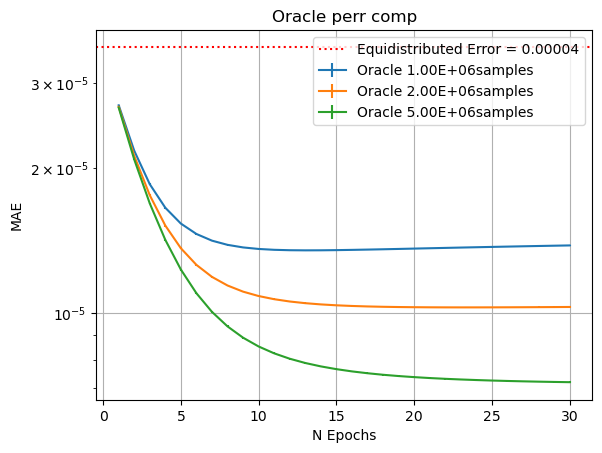

In [150]:
compare_oracle_subsets(20660,subfolder="Oracle_Plot_No_Err/")

We had the problem that the dataset was created with only 10M Reads. So Now we create a 100M dataset and store it in 20642_Prot dataset.

Running again the code but on that one!

In [ ]:
in_path= "/home/jkipen/raid_storage/ProtInfGPU/data/20642_Prot/binary/Oracle"
out_path= "/home/jkipen/ProtInfGPU/results/20642_Prot/Oracle_subsets"
oracle_err=0;
n_epochs=30;
oracle_err=0;
cv_runs=10;
n_threads=512;
subsets=[1000000,2000000,5000000,10000000,20000000,50000000]
for subset in subsets:
    base_command= opt_prot_inf + " " + in_path + " " +out_path 

    command= base_command + " -d 2 -e "+str(n_epochs) +" -c "+str(cv_runs)+" -m 50 -M 30 -s "+str(subset)+" -t " + str(n_threads)+" -o "+str(oracle_err);
    print(command)
    os.system(command)

./../code/cuda/opt.out /home/jkipen/raid_storage/ProtInfGPU/data/20642_Prot/binary/Oracle /home/jkipen/ProtInfGPU/results/20642_Prot/Oracle_subsets -d 2 -e 30 -c 10 -m 50 -M 30 -s 1000000 -t 512 -o 0


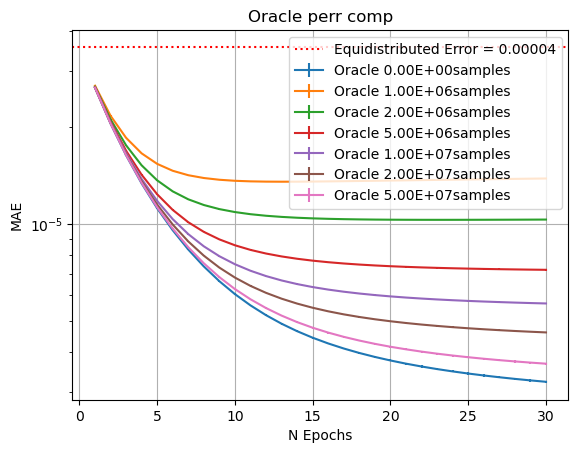

In [152]:
compare_oracle_subsets(20642)

# Retrieving PYEst

Here we debug the retrieving PY_est and plotting it against the true dist.

In [83]:
dir_exp_whole_prot="/home/jkipen/ProtInfGPU/results/50_Prot/Tests/"
dataset_classifier_path="/home/jkipen/raid_storage/ProtInfGPU/data/50_Prot/binary/Oracle/"
def get_PhatYs(path_to_exp):
    n_crossval=int(ret_config(path_to_exp+"/RunConfig.txt","NcrossVal"));
    n_prot=int(ret_config(path_to_exp+"/RunConfig.txt","Nprot"));
    PhatYsConcatenated=np.fromfile(path_to_exp+"/PhatYs.bin", dtype=np.float32);
    PhatYsConcatenated=PhatYsConcatenated.reshape( n_crossval,n_prot);
    return PhatYsConcatenated;
def get_truePIs(ds_classifier_path,n_datasets=10):
    crossvalPath=ds_classifier_path+"CrossVal/";
    PYs_list=[];
    for i in range(n_datasets):
        PYs_list.append(np.fromfile(crossvalPath+"TrueProtDist"+str(i)+".bin", dtype=np.float32))
    PYs = np.column_stack(PYs_list).T 
    return PYs;
PhatYsConcatenated=get_PhatYs(dir_exp_whole_prot+"27-02-2025_19-42-22")
np.shape(PhatYsConcatenated)

(5, 50)

In [88]:
PYs=get_truePIs(dataset_classifier_path)
PYs_compare=PYs[:5,:];

In [89]:
np.mean(np.abs(PYs_compare-PhatYsConcatenated))

0.0011442017

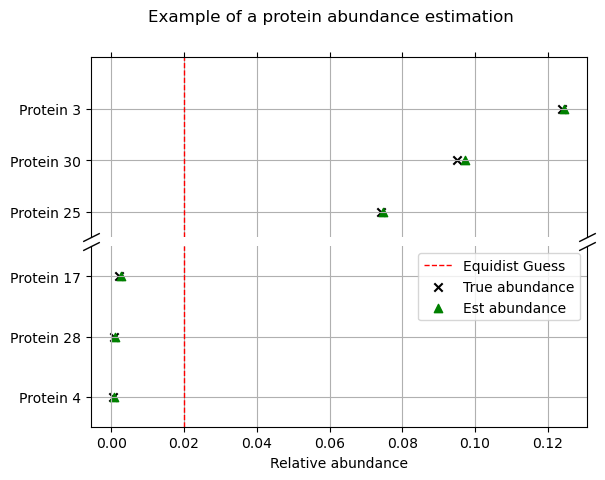

In [129]:
#From https://matplotlib.org/stable/gallery/subplots_axes_and_figures/broken_axis.html
n_ds_cv=0; #Which crossval are we plotting.
n_prot=np.shape(PYs)[1];

PY=PYs_compare[n_ds_cv,:];
PhatY=PhatYsConcatenated[n_ds_cv,:];
prot_indexes=np.argsort(PY) #We want the probs ordered, with higher on the top

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0.05)  # adjust space between Axes

ax1.scatter(PY[prot_indexes], np.arange(n_prot), color='black', marker='x',label="True abundance")
ax1.scatter(PhatY[prot_indexes], np.arange(n_prot), color='green', marker='^',label="Est abundance")
ax1.axvline(x=1/n_prot, color='red', linestyle='--', linewidth=1,label="Equidist Guess")

ax2.axvline(x=1/n_prot, color='red', linestyle='--', linewidth=1,label="Equidist Guess")
ax2.scatter(PY[prot_indexes], np.arange(n_prot), color='black', marker='x',label="True abundance")
ax2.scatter(PhatY[prot_indexes], np.arange(n_prot), color='green', marker='^',label="Est abundance")



ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

ax1.set_yticks(np.arange(n_prot,dtype=np.uint32)) 
protein_labels = [f"Protein {idx}" for idx in prot_indexes]
ax1.set_yticklabels(protein_labels)
ax2.set_yticks(np.arange(n_prot,dtype=np.uint32))  
ax2.set_yticklabels(protein_labels)

ax1.set_ylim(n_prot-3.5, n_prot)  # outliers only
ax2.set_ylim(-0.5, 2.5)  # most of the data

ax1.grid()
ax2.grid()


ax2.legend()

plt.xlabel("Relative abundance")
fig.suptitle("Example of a protein abundance estimation") 
plt.savefig("Example Protein abundance.png")


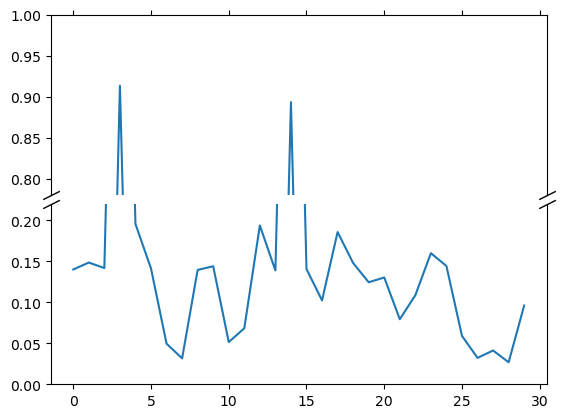

In [90]:
np.random.seed(19680801)

pts = np.random.rand(30)*.2
# Now let's make two outlier points which are far away from everything.
pts[[3, 14]] += .8

# If we were to simply plot pts, we'd lose most of the interesting
# details due to the outliers. So let's 'break' or 'cut-out' the y-axis
# into two portions - use the top (ax1) for the outliers, and the bottom
# (ax2) for the details of the majority of our data
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0.05)  # adjust space between Axes

# plot the same data on both Axes
ax1.plot(pts)
ax2.plot(pts)

# zoom-in / limit the view to different portions of the data
ax1.set_ylim(.78, 1.)  # outliers only
ax2.set_ylim(0, .22)  # most of the data

# hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# Now, let's turn towards the cut-out slanted lines.
# We create line objects in axes coordinates, in which (0,0), (0,1),
# (1,0), and (1,1) are the four corners of the Axes.
# The slanted lines themselves are markers at those locations, such that the
# lines keep their angle and position, independent of the Axes size or scale
# Finally, we need to disable clipping.

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)


plt.show()

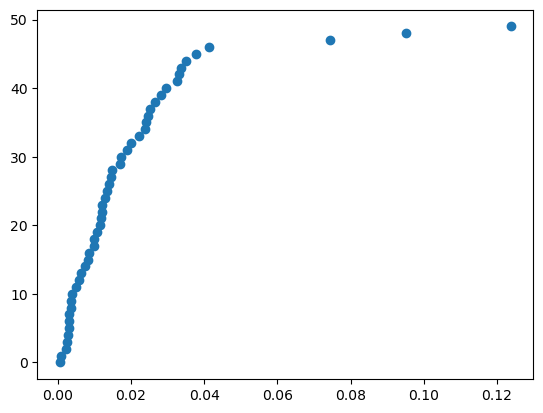

In [101]:
plt.scatter(PY[prot_indexes],np.arange(n_prot))

In [133]:
nFluExpForI=np.fromfile("/home/jkipen/ProtInfGPU/dev/OptKernel/data/nFluExpForI.bin", dtype=np.uint32)
nFluExpForI

array([19, 14, 18, ..., 13, 24, 17], dtype=uint32)

In [146]:
list_n_proteins_per_block=np.arange(150,200);
for n_proteins_per_block in list_n_proteins_per_block:
    n_chunks = int(np.ceil(len(nFluExpForI) / n_proteins_per_block))  
    list_sub_groups=np.array_split(nFluExpForI, n_chunks)
    max_value=np.max([np.sum(i) for i in list_sub_groups])
    print(f"n_proteins_per_block = {n_proteins_per_block}, max sum = {max_value}")
    

n_proteins_per_block = 150, max sum = 4979
n_proteins_per_block = 151, max sum = 4916
n_proteins_per_block = 152, max sum = 4929
n_proteins_per_block = 153, max sum = 5116
n_proteins_per_block = 154, max sum = 5116
n_proteins_per_block = 155, max sum = 5200
n_proteins_per_block = 156, max sum = 5152
n_proteins_per_block = 157, max sum = 5221
n_proteins_per_block = 158, max sum = 5186
n_proteins_per_block = 159, max sum = 5184
n_proteins_per_block = 160, max sum = 5184
n_proteins_per_block = 161, max sum = 5241
n_proteins_per_block = 162, max sum = 5237
n_proteins_per_block = 163, max sum = 5161
n_proteins_per_block = 164, max sum = 5274
n_proteins_per_block = 165, max sum = 5274
n_proteins_per_block = 166, max sum = 5545
n_proteins_per_block = 167, max sum = 5452
n_proteins_per_block = 168, max sum = 5442
n_proteins_per_block = 169, max sum = 5442
n_proteins_per_block = 170, max sum = 5583
n_proteins_per_block = 171, max sum = 5625
n_proteins_per_block = 172, max sum = 5625
n_proteins_

1113